In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from minirocket import fit, transform
from sklearn.decomposition import PCA
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from joblib import Parallel, delayed

def normalize_subsequences(subsequences):
    """Normalize each subsequence individually."""
    # Calculate mean and std for each subsequence
    means = np.mean(subsequences, axis=1, keepdims=True)
    stds = np.std(subsequences, axis=1, keepdims=True)
    # To avoid division by zero, set stds that are zero to 1
    stds[stds == 0] = 1
    # Normalize subsequences
    normalized_subsequences = (subsequences - means) / stds
    return normalized_subsequences

def KNN_norm(k_neighbors, train_windows, test_windows):
    # Normalize each subsequence individually
    train_windows_norm = normalize_subsequences(train_windows)
    test_windows_norm = normalize_subsequences(test_windows)
    
    # Use standard Euclidean distance
    nbrs = NearestNeighbors(n_neighbors=k_neighbors)
    nbrs.fit(train_windows_norm)
    distances, indices = nbrs.kneighbors(test_windows_norm)
    avg_distances = distances.mean(axis=1)
    return avg_distances

def KNN(k_neighbors, train_windows, test_windows):
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(train_windows)
    distances, indices = nbrs.kneighbors(test_windows)
    avg_distances = distances.mean(axis=1)
    #avg_distances = distances.max(axis=1)
    return avg_distances
    
def MiniRocket_KNN_fit(train_windows, num_features=100):
    train_windows = train_windows.astype(np.float32)
    para = fit(train_windows, num_features=num_features)
    return para

def mutual_information(X, Y):
    """Calculate mutual information between two arrays."""
    return mutual_info_score(X, Y)

def calculate_entropy(X):
    """Calculate entropy for a single array."""
    return entropy(X)

def calculate_energy_parallel(train_windows, keep_features_ratio=0.1, num_samples=100):
    """
    Calculate energy function to select most useful kernels.
    
    The energy function E(X_i) for each feature X_i is defined as:
    
    E(X_i) = -Σ_{j=1}^{n} MI(X_i, X_j) + H(X_i)
    
    Where:
    - MI(X_i, X_j) is the mutual information between features X_i and X_j:
    
    MI(X_i, X_j) = Σ_{x ∈ X_i} Σ_{y ∈ X_j} P(x, y) log(P(x, y) / (P(x) P(y)))
    
    - H(X_i) is the entropy of the feature X_i:
    
    H(X_i) = -Σ_{x ∈ X_i} P(x) log P(x)
    
    We sort the features based on the energy values and select the top k features with the lowest energy:
    
    k = int(keep_features_ratio * num_features)
    keep_indices = np.argsort(energy)[:k]
    """
    #print(train_windows.shape)
    #round train_windows to 3 decimal places
    train_windows = np.round(train_windows, 3)
    #print(train_windows[:1])
    num_features = train_windows.shape[1]
    num_pairs = int(num_features * (num_features - 1) / 2)
    
    # Randomly sample a subset of feature pairs for mutual information calculation
    sampled_pairs = np.random.choice(num_pairs, size=min(num_samples, num_pairs), replace=False)
    
    # Calculate entropy for each feature in parallel
    entropies = Parallel(n_jobs=-1)(delayed(calculate_entropy)(train_windows[:, i]) for i in range(num_features))
    entropies = np.array(entropies)
    
    # Calculate mutual information for sampled pairs in parallel
    energy = np.zeros(num_features)
    
    def calculate_pair_energy(i, j):
        mi = mutual_information(train_windows[:, i], train_windows[:, j])
        energy[i] -= mi
        energy[j] -= mi
    
    Parallel(n_jobs=-1)(delayed(calculate_pair_energy)(i, j) for i in range(num_features) for j in range(i + 1, num_features) if (i * num_features + j - (i + 1) * (i + 2) // 2) in sampled_pairs)
    
    # Add entropy contribution to the energy
    energy += entropies
    
    # Select features with lowest energy
    keep_features = int(keep_features_ratio * num_features)
    keep_indices = np.argsort(energy)[:keep_features]
    
    return keep_indices

def MiniRocket_mask(para, train_windows, keep_features_ratio=0.1, num_samples=100):
    train_windows = train_windows.astype(np.float32)
    train_windows = transform(train_windows, para)
    filter_type = 'energy'
    if keep_features_ratio == 1.0:
        mask = np.ones(train_windows.shape[1])
        return mask

    if filter_type == 'energy':
    # Calculate energy function to select features
        keep_indices = calculate_energy_parallel(train_windows, keep_features_ratio, num_samples)
        
        # Create mask with 1 for kept features and 0 for others
        mask = np.zeros(train_windows.shape[1])

    elif filter_type == 'std':
            # Calculate standard deviation for each feature
        std_devs = np.std(train_windows, axis=0)
        
        # Get indices of features to keep (features with the smallest std deviation)
        keep_features = int(keep_features_ratio * train_windows.shape[1])
        # keep largest std deviations
        keep_indices = np.argpartition(std_devs, -keep_features)[-keep_features:]

        # keep smallest std deviations
        #keep_indices = np.argpartition(std_devs, keep_features)[:keep_features]
        
        # Create mask with 1 for kept features and 0 for others
        mask = np.zeros_like(std_devs)

    mask[keep_indices] = 1.0
    return mask

def remove_masked_columns(data, mask):
    # Identify the columns to keep (mask value is 1)
    keep_indices = np.where(mask != 0)[0]
    # Keep only the columns that are not masked out
    cleaned_data = data[:, keep_indices]
    return cleaned_data

def MiniRocket_KNN(para, mask, k_neighbors, train_windows, test_windows=None, use_pca=False, pca_variance_ratio=0.8):
    train_windows = train_windows.astype(np.float32)
    if test_windows is not None:
        test_windows = test_windows.astype(np.float32)
    train_windows = transform(train_windows, para)

    if test_windows is not None:
        test_windows = transform(test_windows, para)
    
    # Remove columns according to the mask
    train_windows = remove_masked_columns(train_windows, mask)
    if test_windows is not None:
        test_windows = remove_masked_columns(test_windows, mask)

    # Apply PCA if applicable
    pca = None
    if use_pca:
        pca = PCA(n_components=pca_variance_ratio)
        train_windows = pca.fit_transform(train_windows)
        if test_windows is not None:
            test_windows = pca.transform(test_windows)

    # Perform KNN
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto').fit(train_windows)
    if test_windows is None:
        distances, indices = nbrs.kneighbors(train_windows)
    else:
        distances, indices = nbrs.kneighbors(test_windows)
    # mean distance for each test window
    avg_distances = distances.mean(axis=1)
    # max distance for each test window
    #avg_distances = distances.max(axis=1)

    return avg_distances

In [2]:
## 20Papers data profile
data_profile = {'Type1_T1_23_ForestFire':{
                                        'win':10,
                                        'weight': [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
                                        'start_idx' : 10*2,
                                        'important_features':[11,12,14,15],
                                         },

               'Damp ECG 60 Seconds':{
                                      'win':260,
                                      'weight': [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0.2, 0.2, 0. , 0. , 0. , 0. , 0. , 0.2, 0.2],
                                      'start_idx' : 260*2,
                                      'important_features':[9, 13, 14, 20, 21],
                                        },
               'yahoo_real_57':{
                                      'win':20,
                                      'weight': [0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
                                      'start_idx' : 200,
                                      'important_features':[3,7],
                                        },
               'yahoo_real_61':{
                                      'win':50,
                                      'weight': [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                                      'start_idx' : 200,
                                      'important_features':[16],
                                        },
               'yahoo_real_7':{
                                      'win':25,
                                      'weight': [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.33, 0.  , 0.  , 0.],
                                      'start_idx' : 125,
                                      'important_features':[11, 16, 18],
                                        },
               'telemanom':{
                                      'win':110,
                                      'weight': [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                      'start_idx' : 1100,
                                      'important_features':[9],
                                        },
               '051_UCR_Anomaly_DISTORTEDTkeepSecondMARS_3500_9330_9340':{
                                      'win':90,
                                      'weight': [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
                                      'start_idx' : 180,
                                      'important_features':[21],
                                        },
               '144_UCR_Anomaly_InternalBleeding9_4200_6599_6681':{
                                      'win':110,
                                      'weight': [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.33333333, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.33333333, 0.        , 0.        , 0.33333333],
                                      'start_idx' : 220,
                                      'important_features':[11, 18, 21],
                                        },
               '140_UCR_Anomaly_InternalBleeding4_1000_4675_5033':{
                                      'win':400,
                                      'weight': [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25],
                                      'start_idx' : 800,
                                      'important_features':[ 9, 17, 18, 21],
                                        },
               '162_UCR_Anomaly_WalkingAceleration5_2700_5920_5979':{
                                      'win':100,
                                      'weight': [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0.2, 0.2, 0.2, 0. , 0. , 0.2],
                                      'start_idx' : 200,
                                      'important_features':[ 21, 18, 17, 16, 14],
                                        },
            #    'PV_System':{
            #                           'win':60,
            #                           'weight': [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ],
            #                           'start_idx' : 120,
            #                           'important_features':[ 5,16],
            #                           'speed_up_earlly_abaondon': True
            #                             },
            #    'PV_System':{
            #                           'win':60,
            #                           'weight': [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
            #                           'start_idx' : 120,
            #                           'important_features':[ 1,11],
            #                             },
               'PV_System':{
                                      'win':60,
                                      'weight': [0.02938755, 0.42049578, 0.01163001, 0.00772628, 0.00452387, 0.02097435, 0.02400663, 0.01156038, 0.01327693, 0.00873132, 0.0111595 , 0.20246564, 0.02176801, 0.04314136, 0.01342441, 0.        , 0.02748599, 0.02449168, 0.01261935, 0.04784086, 0.00139489, 0.04189511],
                                      'start_idx' : 120,
                                      'important_features':None,
                                        },
            #    'MGAB':{
            #                           'win':200,
            #                           'weight': [0.06449375, 0.07247635, 0.00819315, 0.11884118, 0.11400852, 0.00475168, 0.49829966, 0.07151536, 0.03786842, 0.02407343, 0.1329125 , 0.27917254, 0.23236551, 0.26880966, 0.58686602, 0.03755225, 0.03647213, 0.72511363, 0.21204127, 0.19040656, 0.06114076, 1.07224342],
            #                           'start_idx' : 800,
            #                           'important_features':None,
            #                             },
                'MGAB':{
                                      'win':200,
                                      'weight': [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,0. , 0. , 0. , 0. , 0. , 0., 1., 0. , 0. ],
                                      'start_idx' : 800,
                                      'important_features':[19],
                                        },
                'water_quality ts7':{
                                      'win':250,
                                      'weight': [0.        , 0.        , 0.        , 0.        , 0.        ,0.        , 0.33333333, 0.        , 0.        , 0.        ,0.33333333, 0.        , 0.        , 0.        , 0.        ,0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.33333333],
                                      'start_idx' : 500,
                                      'important_features':[6,10,21],
                                        },
                'ecg':{
                                      'win':200,
                                      'weight': [1.57163015, 0.73162794, 0.06357856, 0.17857337, 0.02423702, 0.39605513, 0.13169685, 0.16272531, 0.07537306, 0.02566005, 0.25104092, 0.37423977, 0.06390653, 1.83134486, 5.91548694, 0.29073278, 1.93207352, 1.34150613, 3.41343527, 0.98436899, 0.36257556, 6.3608759 ],
                                      'start_idx' : 400,
                                      'important_features':None,
                                        },
                'AIOps':{
                                      'win':142,
                                      'weight': [1.90674236e+01, 1.22259838e+01, 9.59629800e-01, 2.78082776e+00,2.92381276e-01, 1.97275293e+01, 2.65583326e+01, 3.05382397e+01,1.08507512e+01, 5.06925920e+00, 1.11755581e+01, 1.12881210e+01,3.49637048e+01, 4.43131137e+01, 4.22221460e+01, 5.22540087e+01,2.27271965e+01, 4.78353068e+00, 3.69696473e+01, 1.05407853e+01,1.72643250e-01, 2.74389161e+02],
                                      'start_idx' : 1000,#284,
                                      'important_features':None,
                                        },
                'AIOps_2':{
                                      'win':20,
                                      'weight': [5.52305349e-01, 1.41473403e+00, 4.33923864e-01, 2.30112982e-02,1.33226763e-15, 9.76791838e-02, 4.79331905e-01, 2.31814158e+00,3.44334818e+00, 1.01971223e-01, 8.14405617e-02, 7.65780381e-01,1.18499497e+00, 2.93515814e+00, 1.33489037e+00, 3.19963257e+00,2.60752258e+00, 5.57520444e-02, 2.26491715e+00, 6.81285091e-01,0.00000000e+00, 2.77044597e+00],
                                      'start_idx' : 220,
                                      'important_features':None,
                                        },
                # 'twitter':{
                #                       'win':300,
                #                       'weight': [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0.],
                #                       'start_idx' : 2500,
                #                       'important_features':[17,18],#xgb_weights
                #                         },
                'twitter_ieee':{
                                      'win':300,
                                      'weight': [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ,0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
                                      'start_idx' : 600,
                                      'important_features':[11,17],#xgb_weights
                                        },
                'HAI_test1_36':{
                                      'win':350,
                                      'weight': [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0. , 0. ],
                                      'start_idx' : 700,
                                      'important_features':[9, 12, 17, 18, 19],
                                        },
                'HAI_test2_57':{
                                      'win':50,
                                      'weight': [1.85253232e+01, 2.10942089e+01, 1.05075791e+01, 1.57617021e+01,4.56475643e+00, 1.01818853e+01, 1.00609929e+01, 2.53020902e+01,3.80730607e+01, 2.28698581e+02, 1.31926542e+02, 1.22768163e+01,1.08199845e+01, 1.17374700e+01, 2.03338004e+01, 4.08065932e+00,1.69934215e+01, 1.67326325e+00, 1.05881264e+01, 4.19804412e+00,4.01113980e-02, 1.17623865e+01],
                                      'start_idx' : 1000,
                                      'important_features':None,
                                        },
                'seismic':{
                                      'win':50,
                                      'weight': [0.        , 0.        , 0.        , 0.        , 0.        ,0.        , 0.        , 0.        , 0.        , 0.        ,0.        , 0.33333333, 0.33333333, 0.        , 0.        ,0.        , 0.        , 0.        , 0.        , 0.        ,0.        , 0.33333333],
                                      'start_idx' : 100,
                                      'important_features':[11,12,21],
                                        },
                'cpu':{
                                      'win':10,
                                      'weight': [8.95428165e+00, 8.11093466e+00, 3.08807254e+00, 2.78812916e+00,2.48689958e-14, 7.11859442e+00, 1.09523288e+01, 7.48064911e+00,8.99941251e+00, 3.26183789e+01, 7.52808592e+00, 1.26322328e+01,8.99148542e+00, 1.80994912e+01, 2.48689958e-14, 3.38429635e+01,5.79862971e+01, 8.50886644e+00, 1.96126149e+00, 1.99762452e+00,0.00000000e+00, 2.59638250e+00],
                                      'start_idx' : 60,
                                      'important_features':None,
                                        },
                'MSCRED':{
                                      'win':250,
                                      'weight': [0.        , 0.        , 0.        , 0.        , 0.        ,0.        , 0.33333333, 0.        , 0.        , 0.        ,0.        , 0.        , 0.        , 0.        , 0.        ,0.        , 0.        , 0.        , 0.        , 0.33333333,0.33333333, 0.        ],
                                      'start_idx' : 50,
                                      'important_features':[6, 19, 20],
                                        },
               'NewyorkTaxi':{
                                      'win':48,
                                      'weight': [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.25, 0.  , 0.25, 0.  , 0.  , 0.25],
                                      'start_idx' : 480,
                                      'important_features':[18, 14, 16, 21],
                                        }
               }

data_sets_names = [
    'Type1_T1_23_ForestFire.csv',
    'yahoo_real_57.csv',
    'Damp ECG 60 Seconds.csv',
    'yahoo_real_7.csv',
    'telemanom.csv',
    '162_UCR_Anomaly_WalkingAceleration5_2700_5920_5979.csv',
    '144_UCR_Anomaly_InternalBleeding9_4200_6599_6681.csv',
    'PV_System.csv',
    'MGAB.csv',
    'water_quality ts7.csv',
    'ecg.csv',
    'AIOps.csv',
    'twitter_ieee.csv',
    'AIOps_2.csv',
    'HAI_test1_36.csv',
    'HAI_test2_57.csv',
    'seismic.csv',
    'cpu.csv',
    'MSCRED.csv',
    'NewyorkTaxi.csv'
]

data_set_keys = [
    'ForestFire',
    'YahooReal57',
    'DAMP',
    'YahooReal7',
    'Telemanom',
    'WalkingAceleration',
    'InternalBleeding',
    'PVSystem',
    'MGAB',
    'WaterQuality',
    'ECG',
    'AIOps',
    'Twitter',
    'AIOps2',
    'HAITest136',
    'HAITest257',
    'Seismic',
    'CPU',
    'MSCRED',
    'NewyorkTaxi'
]

In [3]:
# Normalization functions and scoring metrics
def normalize(a):
    a = a / np.maximum(np.absolute(a.max(axis=0)), np.absolute(a.min(axis=0)))
    return (a / 2 + 0.5)

def normalize2(a, min_a=None, max_a=None):
    if min_a is None: min_a, max_a = min(a), max(a)
    return (a - min_a) / (max_a - min_a), min_a, max_a

def normalize3(a, min_a=None, max_a=None):
    if min_a is None: min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

### evenly select in range(10, AT)

In [117]:
#read data from data/UCR/135_UCR
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from scipy.signal import find_peaks, correlate
import math
import pandas as pd
import json
import time

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

dataset = '20Papers'

#window_sizes = [10, 50, 100, 200]
k_neighbors = 3
model = 'MiniRocket_KNN'

def calculate_window_size(data):
    # Calculate autocorrelation
    autocor = correlate(data, data, mode='full')
    autocor = autocor[len(autocor)//2:]

    # Define the range for finding peaks
    peak_range = np.arange(10, min(len(autocor), 1001))

    # Find peaks in the specified range of the autocorrelation
    peaks, _ = find_peaks(autocor[peak_range], distance=10)
    
    # Adjust peak indices to correspond to the original autocorrelation
    peaks = peak_range[peaks]
    
    # Set window size based on the first peak found
    if len(peaks) > 0:
        #print(peaks)
        m = peaks[0]
    else:
        m = 80
    
    return int(np.floor(m))

def select_window_sizes(upper_bound, lower_bound=10, num_candidates=4):
    # Ensure the upper bound is greater than the lower bound
    if upper_bound <= lower_bound:
        raise ValueError("Upper bound must be greater than lower bound.")
    
    # Calculate evenly spaced candidates within the range
    window_sizes = np.linspace(lower_bound, upper_bound, num_candidates, dtype=int)
    
    return window_sizes

def select_incremental_window_sizes(upper_bound, lower_bound=10, num_candidates=4):
    increment = (upper_bound - lower_bound) // (num_candidates - 1)
    return np.unique([lower_bound + i * increment for i in range(num_candidates)])

def select_best_window_size(point_anomaly_scores_list, window_sizes):
    max_differences = []
    
    for i, scores in enumerate(point_anomaly_scores_list):
        # Find the highest anomaly score and its index
        max_score = np.max(scores)
        max_index = np.argmax(scores)
        
        # Define the exclusion range for the second-highest point
        exclusion_start = max(0, max_index - window_sizes[i])
        exclusion_end = min(len(scores), max_index + window_sizes[i])
        
        # Mask out the range around the highest point
        masked_scores = np.copy(scores)
        masked_scores[exclusion_start:exclusion_end] = -np.inf  # Exclude this range by setting to -inf

        # Find the second-highest score outside the exclusion range
        second_max_score = np.max(masked_scores)
        
        # Calculate the score difference for the current window size
        score_difference = max_score - second_max_score
        max_differences.append(score_difference)
        
    # Find the window size with the maximum score difference
    best_index = np.argmax(max_differences)
    best_window_size = window_sizes[best_index]
    anomaly_scores = point_anomaly_scores_list[best_index]
    
    return best_window_size, anomaly_scores

def detect_delimiter(file_path):
    with open(file_path, 'r') as file:
        line = file.readline()
        if ',' in line:
            return ','
        elif '\t' in line:
            return '\t'
        else:
            return ' '
        
if dataset == 'UCR':
    dataset_folder = "E:\\Code\\Time_Series_Datasets\\UCR_Anomaly_FullData"
    file_list = os.listdir(dataset_folder)
    file_list = file_list[:]

elif dataset == 'NAB':
    dataset_folder = 'data/NAB'
    file_list = os.listdir(dataset_folder)
    with open(dataset_folder + '/labels.json') as f:
        labeldict = json.load(f)
    #file_list = file_list[1:2]

elif dataset == 'MSDS':
    dataset_folder = 'data/MSDS'
    file_list = os.listdir(dataset_folder)
    file_list = file_list[1:2]

elif dataset == 'SWaT':
    dataset_folder = 'data/SWaT'
    file_list = os.listdir(dataset_folder)
    file_list = file_list[1:2]

elif dataset == 'WhiteFly':
    dataset_folder = 'data/WhiteFly'
    file_list = os.listdir(dataset_folder)
    file_list = file_list[0:1]

elif dataset == '20Papers':
    dataset_folder = 'data/20Papers'
    file_list = data_sets_names
    data_ind = 17
    file_list = file_list[data_ind:data_ind+1]
               
accuracy_scores = 0

# Result storage list
results = []
start_time = time.time()
for filename in file_list:
    print(filename)

    if dataset == 'UCR':
        if not filename.endswith('.txt'): continue
        vals = filename.split('.')[0].split('_')
        dnum, vals = int(vals[0]), vals[-3:]
        vals = [int(i) for i in vals]
        #delimiter = detect_delimiter(os.path.join(dataset_folder, filename))
        #temp = np.genfromtxt(os.path.join(dataset_folder, filename), dtype=np.float64, delimiter=delimiter)
        temp = np.loadtxt(dataset_folder + '\\' + filename)
        min_temp, max_temp = np.min(temp), np.max(temp)
        temp = (temp - min_temp) / (max_temp - min_temp)
        train, test = temp[:vals[0]], temp[vals[0]:]
        labels = np.zeros_like(test)
        labels[vals[1]-vals[0]:vals[2]-vals[0]] = 1
        train, test, labels = train.reshape(-1, 1), test.reshape(-1, 1), labels.reshape(-1, 1)

    elif dataset == 'NAB':
        if not filename.endswith('.csv'): continue
        df = pd.read_csv(dataset_folder+'/'+filename)
        vals = df.values[:,1]
        labels = np.zeros_like(vals, dtype=np.float64)
        for timestamp in labeldict['realKnownCause/'+filename]:
            tstamp = timestamp.replace('.000000', '')
            index = np.where(((df['timestamp'] == tstamp).values + 0) == 1)[0][0]
            labels[index-4:index+4] = 1
        min_temp, max_temp = np.min(vals), np.max(vals)
        vals = (vals - min_temp) / (max_temp - min_temp)
        train, test = vals.astype(float), vals.astype(float)
        train, test, labels = train.reshape(-1, 1), test.reshape(-1, 1), labels.reshape(-1, 1)
    
    elif dataset == 'MSDS':
        df_train = pd.read_csv(os.path.join(dataset_folder, 'train.csv'))
        df_test  = pd.read_csv(os.path.join(dataset_folder, 'test.csv'))
        df_train, df_test = df_train.values[::5, 1:], df_test.values[::5, 1:]
        _, min_a, max_a = normalize3(np.concatenate((df_train, df_test), axis=0))
        train, _, _ = normalize3(df_train, min_a, max_a)
        test, _, _ = normalize3(df_test, min_a, max_a)
        labels = pd.read_csv(os.path.join(dataset_folder, 'labels.csv'))
        labels = labels.values[::1, 1:]
    
    elif dataset == 'SWaT':
        file = os.path.join(dataset_folder, 'series.json')
        df_train = pd.read_json(file, lines=True)[['val']][3000:6000]
        df_test  = pd.read_json(file, lines=True)[['val']][7000:12000]
        train, min_a, max_a = normalize2(df_train.values)
        test, _, _ = normalize2(df_test.values, min_a, max_a)
        labels = pd.read_json(file, lines=True)[['noti']][7000:12000] + 0
        # convert pandas DataFrame to numpy
        train, test, labels = np.array(train), np.array(test), np.array(labels)
    
    elif dataset == 'WhiteFly':
        data = pd.read_csv(os.path.join(dataset_folder, filename))
        split_index = 50000

        train = data.iloc[:split_index, 1].values.reshape(-1, 1)  # Training data
        test = data.iloc[split_index:, 1].values.reshape(-1, 1)   # Testing data
        labels = data.iloc[:, 2].values.reshape(-1, 1)  # Test labels

        min_val = np.min(train)
        max_val = np.max(train)
        train = (train - min_val) / (max_val - min_val)
        test = (test - min_val) / (max_val - min_val)

        train, test, labels = train.reshape(-1, 1), test.reshape(-1, 1), labels.reshape(-1, 1)
    
    elif dataset == '20Papers':
        data_name = filename.split('.csv')[0]
        dataset_name = data_set_keys[data_sets_names.index(filename)]
        print("Data name:", dataset_name)

        start_idx = data_profile[data_name]['start_idx']
        winsize = data_profile[data_name]['win']
        print("window size:", winsize)

        data = pd.read_csv(os.path.join(dataset_folder, filename))

        train = data.iloc[:start_idx, 1].values.reshape(-1, 1)  # Training data
        test = data.iloc[start_idx:, 1].values.reshape(-1, 1)   # Testing data
        labels = data.iloc[:, 2].values.reshape(-1, 1)  # Test labels

        min_val = np.min(train)
        max_val = np.max(train)
        train = (train - min_val) / (max_val - min_val)
        test = (test - min_val) / (max_val - min_val)

        train, test, labels = train.reshape(-1, 1), test.reshape(-1, 1), labels.reshape(-1, 1)


    data = np.concatenate([train, test], axis=0)
    
    window_size = calculate_window_size(train.flatten())
    window_sizes = select_incremental_window_sizes(upper_bound=window_size, lower_bound=10, num_candidates=4)

    #window_sizes = select_incremental_window_sizes(upper_bound=200, lower_bound=10, num_candidates=4)
    #window_sizes = [300]
    print('Window Sizes:', window_sizes)
    
    
    # Segment time series into subsequences
    def create_windows(data, window_size):
        windows = []
        for i in range(len(data) - window_size + 1):
            windows.append(data[i:i + window_size])
        return np.array(windows)
    
    anomaly_scores_list = []
    for window_size in window_sizes:
        # Generate windows for train and test data separately
        train_windows = create_windows(train, window_size)
        test_windows = create_windows(test, window_size)
        train_windows = train_windows.reshape(-1, window_size)
        test_windows = test_windows.reshape(-1, window_size)

        #print('Train Windows:', train_windows.shape)

        # Calculate distances
        if model == 'KNN':
            train_distances = KNN(k_neighbors, train_windows, train_windows)
            test_distances = KNN(k_neighbors, train_windows, test_windows)
        elif model == 'KNN_norm':
            train_distances = KNN_norm(k_neighbors, train_windows, train_windows)
            test_distances = KNN_norm(k_neighbors, train_windows, test_windows)
        elif model == 'MiniRocket_KNN':
            num_features = 1000
            use_pca = False
            pca_variance_ratio = 0.95
            para = MiniRocket_KNN_fit(train_windows, num_features=num_features)
            mask = MiniRocket_mask(para, train_windows, keep_features_ratio=0.5, num_samples=100)
            train_distances = MiniRocket_KNN(para, mask, k_neighbors, train_windows, use_pca=use_pca)
            test_distances = MiniRocket_KNN(para, mask, k_neighbors, train_windows, test_windows, use_pca=use_pca, pca_variance_ratio=pca_variance_ratio)
            #print(test_distances.shape)
        # Calculate anomaly score (train_distances and test_distances)
        #train_distances = np.concatenate([train_distances, np.zeros(window_size-1)])
        #test_distances = np.concatenate([test_distances, np.zeros(window_size-1)])
        train_distances = np.concatenate([np.zeros(window_size-1), np.zeros(len(train_distances))])
        test_distances = np.concatenate([np.zeros(window_size-1), test_distances])
        anomaly_scores = np.concatenate([train_distances, test_distances])
        anomaly_scores_list.append(anomaly_scores)

    # Select the best window size based on the point anomaly scores
    best_window_size, anomaly_scores = select_best_window_size(anomaly_scores_list, window_sizes)
    print('Best Window Size:', best_window_size)
    #anomaly_scores = anomaly_scores[:len(data)]

    # Set threshold
    #threshold = max(anomaly_scores[:vals[0]])
    #anomalies = anomaly_scores > threshold

    # True label
    if dataset == 'UCR':
        true_anomaly_start = vals[1]
        true_anomaly_end = vals[2]
        true_anomaly_starts = [vals[1]]
        true_anomaly_ends = [vals[2]]
    elif dataset == 'WhiteFly':
        # where label == 1
        true_anomaly_start = np.where(labels == 1)[0][0]
        true_anomaly_end = np.where(labels == 1)[0][-1]
    elif dataset == '20Papers':
        true_anomaly_starts = []
        true_anomaly_ends = []
        for i in range(len(labels)):
            if labels[i] == 1 and labels[i-1] == 0:
                true_anomaly_starts.append(i)
            if i+1 < len(labels) and labels[i] == 1 and labels[i+1] == 0:
                true_anomaly_ends.append(i)
            elif i == len(labels)-1 and labels[i] == 1:
                true_anomaly_ends.append(i)
        true_anomaly_start = true_anomaly_starts[0]
        true_anomaly_end = true_anomaly_ends[0]
    
    # Eval
    test_labels = labels[:-window_size+1]

    init_score = train_distances
    test_score = test_distances

    anomaly_location = np.argmax(anomaly_scores)  # Location of the predicted anomaly
    L = max(100, true_anomaly_end - true_anomaly_start)
    is_anomaly_correct = 0
    if true_anomaly_start - L <= anomaly_location <= true_anomaly_end + L:
        accuracy_scores += 1
        is_anomaly_correct = 1
    results.append({"Dataset": filename, "Anomaly_Detected": is_anomaly_correct, "Best Window Size": best_window_size})

# Calculate the average scores
accuracy_scores = accuracy_scores / len(file_list)

results_df = pd.DataFrame(results)
#results_df.to_csv("anomaly_detection_results.csv", index=False)
print("Time taken:", round(time.time() - start_time, 2), "seconds")

print("Average Accuracy Score:", accuracy_scores)

cpu.csv
Data name: CPU
window size: 10
Window Sizes: [10 11 12 13]
Best Window Size: 10
Time taken: 5.07 seconds
Average Accuracy Score: 1.0


len of anomaly: 27
491 518
507 520


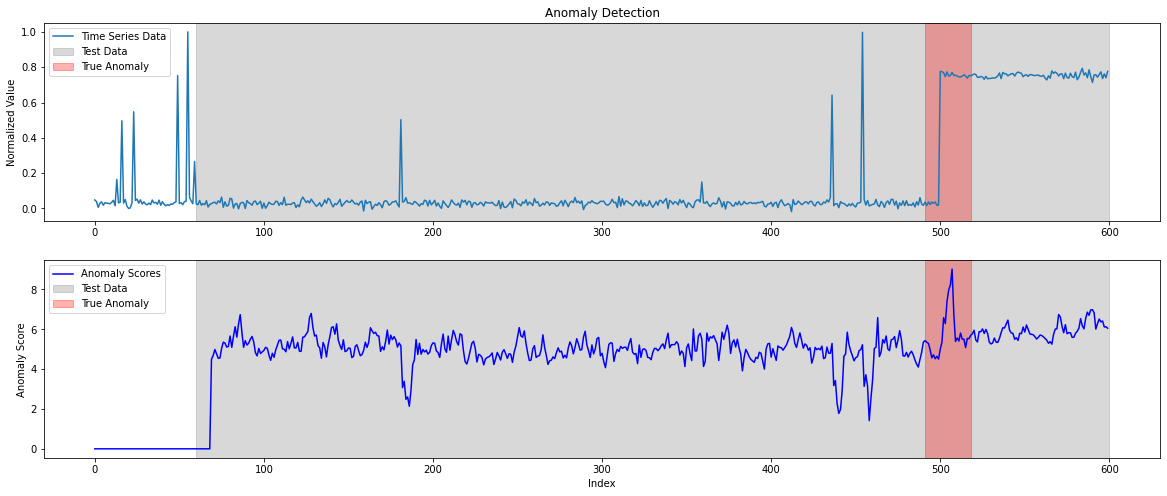

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables are defined: data, train, test, true_anomaly_start, true_anomaly_end, anomaly_scores, threshold, anomalies

# Define the length of training data
train_length = len(train)
print('len of anomaly:', true_anomaly_end - true_anomaly_start)

# Plotting
plt.figure(figsize=(20, 8))

# Upper plot - Time series data and detected anomalies
plt.subplot(2, 1, 1)
plt.plot(data, label='Time Series Data')
plt.axvspan(train_length, len(data), color='gray', alpha=0.3, label='Test Data')
if len(true_anomaly_starts) != 1:
    for true_anomaly_start, true_anomaly_end in zip(true_anomaly_starts, true_anomaly_ends):
        plt.axvspan(true_anomaly_start, true_anomaly_end, color='red', alpha=0.3, label='True Anomaly')
else:
    plt.axvspan(true_anomaly_start, true_anomaly_end, color='red', alpha=0.3, label='True Anomaly')
#anomaly_indices = np.where(anomalies)[0] + train_length + window_size // 2
#plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label='Detected Anomaly')
plt.ylabel('Normalized Value')
plt.title('Anomaly Detection')
plt.legend(loc='upper left')

# Lower plot - Anomaly scores
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(anomaly_scores)), anomaly_scores, color='blue', label='Anomaly Scores')
plt.axvspan(train_length, len(data), color='gray', alpha=0.3, label='Test Data')
if len(true_anomaly_starts) != 1:
    for true_anomaly_start, true_anomaly_end in zip(true_anomaly_starts, true_anomaly_ends):
        plt.axvspan(true_anomaly_start, true_anomaly_end, color='red', alpha=0.3, label='True Anomaly')
else:
    plt.axvspan(true_anomaly_start, true_anomaly_end, color='red', alpha=0.3, label='True Anomaly')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
print(true_anomaly_start, true_anomaly_end)
print(np.argmax(anomaly_scores), np.argmax(anomaly_scores)+window_size)

plt.show()

Anomaly region: 56 to 64 (length = 8)
Max anomaly score index: 61
Windowed max index: 77


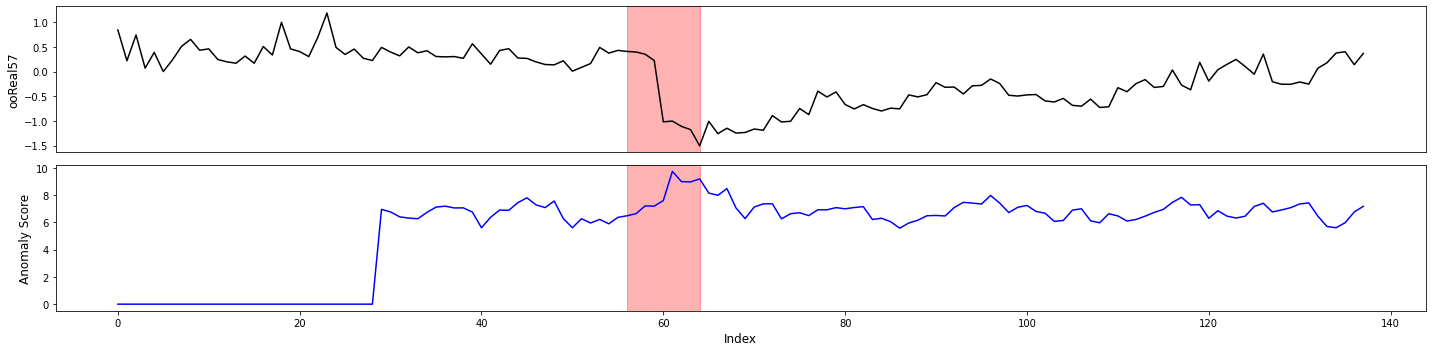

In [23]:
# Print out total anomaly regions and lengths for debugging
for start, end in zip(true_anomaly_starts, true_anomaly_ends):
    print(f"Anomaly region: {start} to {end} (length = {end - start})")

# Create a figure
plt.figure(figsize=(20, 5))

# --- Top subplot: main time series in black ---
ax1 = plt.subplot(2, 1, 1)
ax1.plot(data, color='black')

# Highlight each anomaly region in red
for start, end in zip(true_anomaly_starts, true_anomaly_ends):
    ax1.axvspan(start, end, color='red', alpha=0.3)

# Remove x-axis labels/ticks on the top subplot for a cleaner stacked look
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Label the y-axis (example text "ooReal57")
ax1.set_ylabel('ooReal57', fontsize=12)

# --- Bottom subplot: anomaly scores in blue ---
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(anomaly_scores, color='blue')

# Again, highlight each anomaly region in red
for start, end in zip(true_anomaly_starts, true_anomaly_ends):
    ax2.axvspan(start, end, color='red', alpha=0.3)

# Label axes
ax2.set_xlabel('Index', fontsize=12)
ax2.set_ylabel('Anomaly Score', fontsize=12)

# Print some debug info about maximum anomaly score
max_score_idx = np.argmax(anomaly_scores)
print("Max anomaly score index:", max_score_idx)
print("Windowed max index:", max_score_idx + window_size)

plt.tight_layout()
plt.show()


Anomaly region: 491 to 518 (length = 27)
Max anomaly score index: 507
Windowed max index: 520


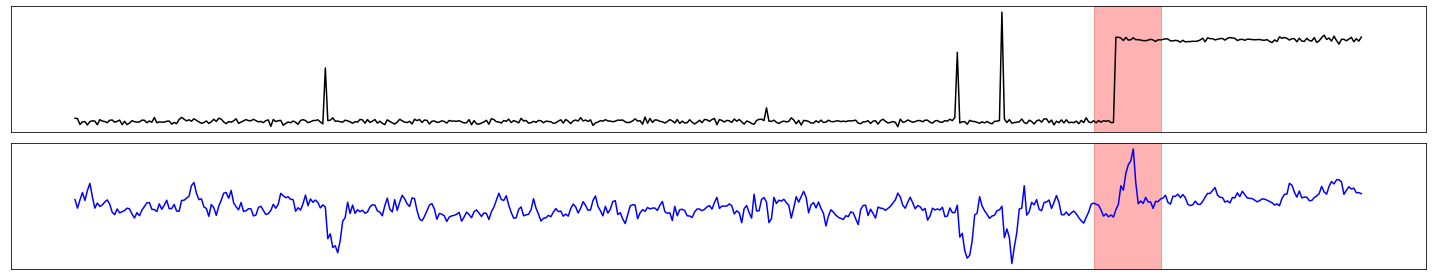

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate where the test portion begins
train_length = len(train)+20
test_range = np.arange(train_length, len(data))

# Debug: print out anomaly regions
for start, end in zip(true_anomaly_starts, true_anomaly_ends):
    print(f"Anomaly region: {start} to {end} (length = {end - start})")

# Create a figure
plt.figure(figsize=(20, 4))

# --- Top subplot: main time series (test only) ---
ax1 = plt.subplot(2, 1, 1)
# Plot data from train_length to end
ax1.plot(test_range, data[train_length:], color='black')

# Highlight each anomaly region, clamped to test range
for start, end in zip(true_anomaly_starts, true_anomaly_ends):
    # Clamp start/end so we don't show training portion
    start_clamped = max(start, train_length)
    end_clamped = min(end, len(data))
    if end_clamped > start_clamped:  # Only highlight if it overlaps test
        ax1.axvspan(start_clamped, end_clamped, color='red', alpha=0.3)

# Remove x-axis labels/ticks on the top subplot for a cleaner stacked look
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Label the y-axis (example: "ooReal57")
#ax1.set_ylabel('ooReal57', fontsize=12)

# --- Bottom subplot: anomaly scores (test only) ---
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(test_range, anomaly_scores[train_length:], color='blue')

# Highlight anomaly regions (again, clamped to test range)
for start, end in zip(true_anomaly_starts, true_anomaly_ends):
    start_clamped = max(start, train_length)
    end_clamped = min(end, len(data))
    if end_clamped > start_clamped:
        ax2.axvspan(start_clamped, end_clamped, color='red', alpha=0.3)

#ax2.set_xlabel('Index (Test Set)', fontsize=12)
#ax2.set_ylabel('Anomaly Score', fontsize=12)

# Debug info about maximum anomaly score in the *entire* array
# (Adjust if you only care about the test portion)
max_score_idx = np.argmax(anomaly_scores)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')
print("Max anomaly score index:", max_score_idx)
print("Windowed max index:", max_score_idx + window_size)

plt.tight_layout()
plt.show()


len of anomaly: 197
Index of max anomaly score: 1817


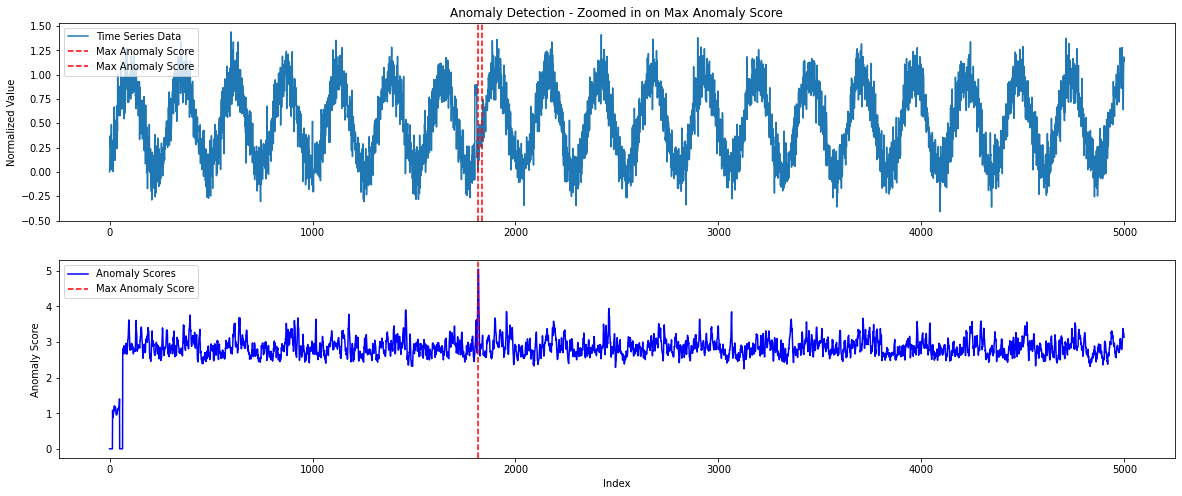

In [12]:
import numpy as np
import matplotlib.pyplot as plt


train_length = len(train)
print('len of anomaly:', true_anomaly_end - true_anomaly_start)

max_anomaly_index = np.argmax(anomaly_scores)
print('Index of max anomaly score:', max_anomaly_index)

window_size = 10000
start_index = max(0, max_anomaly_index - window_size // 2)
end_index = min(len(data), max_anomaly_index + window_size // 2)

x_values = np.arange(start_index, end_index)
data_in_range = data[start_index:end_index]
anomaly_scores_in_range = anomaly_scores[start_index:end_index]

plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
plt.plot(x_values, data_in_range, label='Time Series Data')
plt.axvline(max_anomaly_index, color='red', linestyle='--', label='Max Anomaly Score')
plt.axvline(max_anomaly_index+best_window_size, color='red', linestyle='--', label='Max Anomaly Score')
plt.ylabel('Normalized Value')
plt.title('Anomaly Detection - Zoomed in on Max Anomaly Score')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(x_values, anomaly_scores_in_range, color='blue', label='Anomaly Scores')
plt.axvline(max_anomaly_index, color='red', linestyle='--', label='Max Anomaly Score')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')

plt.show()

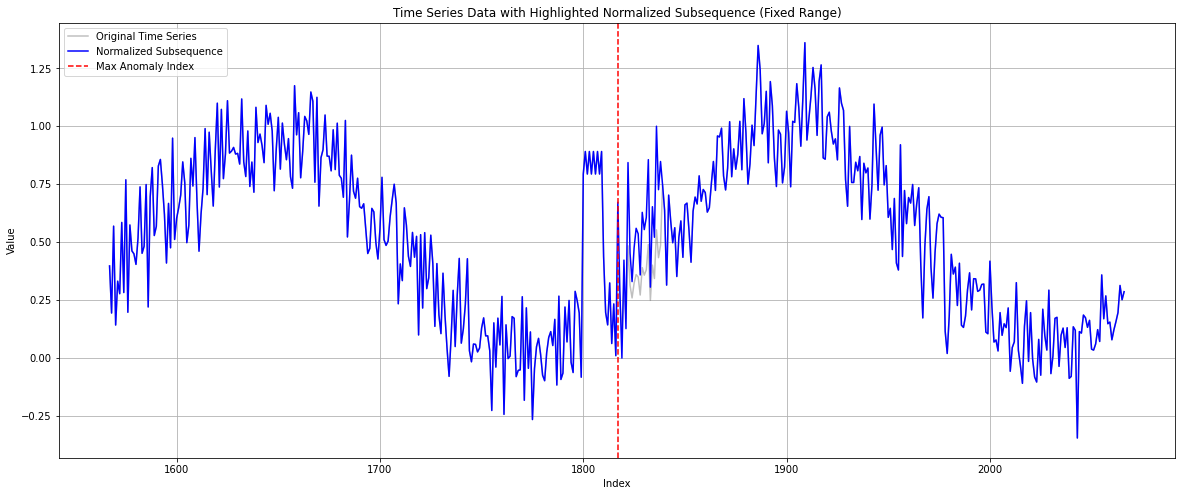

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the subsequence from max_anomaly_index to max_anomaly_index + 22
subsequence_start = max_anomaly_index
subsequence_end = max_anomaly_index + 22

# Ensure indices do not exceed the data length
subsequence_end = min(subsequence_end, len(data))

subsequence = data[subsequence_start:subsequence_end]

# Normalize the subsequence
def normalize(sequence):
    return (sequence - np.min(sequence)) / (np.max(sequence) - np.min(sequence))

normalized_subsequence = normalize(subsequence)

# Define a window around the max_anomaly_index
window_size = 500
start_index = max(0, max_anomaly_index - window_size // 2)
end_index = min(len(data), max_anomaly_index + window_size // 2)

x_values = np.arange(start_index, end_index)
data_in_range = data[start_index:end_index]

# Replace the original subsequence with the normalized one within the fixed range
data_with_normalized_subsequence = np.copy(data_in_range)
if subsequence_start >= start_index and subsequence_end <= end_index:
    relative_start = subsequence_start - start_index
    relative_end = subsequence_end - start_index
    data_with_normalized_subsequence[relative_start:relative_end] = normalized_subsequence

# Plot the time series in the fixed range
plt.figure(figsize=(20, 8))

# Plot the original time series in the fixed range
plt.plot(x_values, data_in_range, label='Original Time Series', color='gray', alpha=0.5)

# Plot the normalized subsequence
plt.plot(x_values, data_with_normalized_subsequence, label='Normalized Subsequence', color='blue')

# Add a vertical line at max_anomaly_index
plt.axvline(max_anomaly_index, color='red', linestyle='--', label='Max Anomaly Index')

# Add labels, legend, and grid
plt.title('Time Series Data with Highlighted Normalized Subsequence (Fixed Range)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid()
plt.show()



True Anomaly Start: 1711 End: 1908
Max Anomaly Score Index: 1817 Window Size: 500


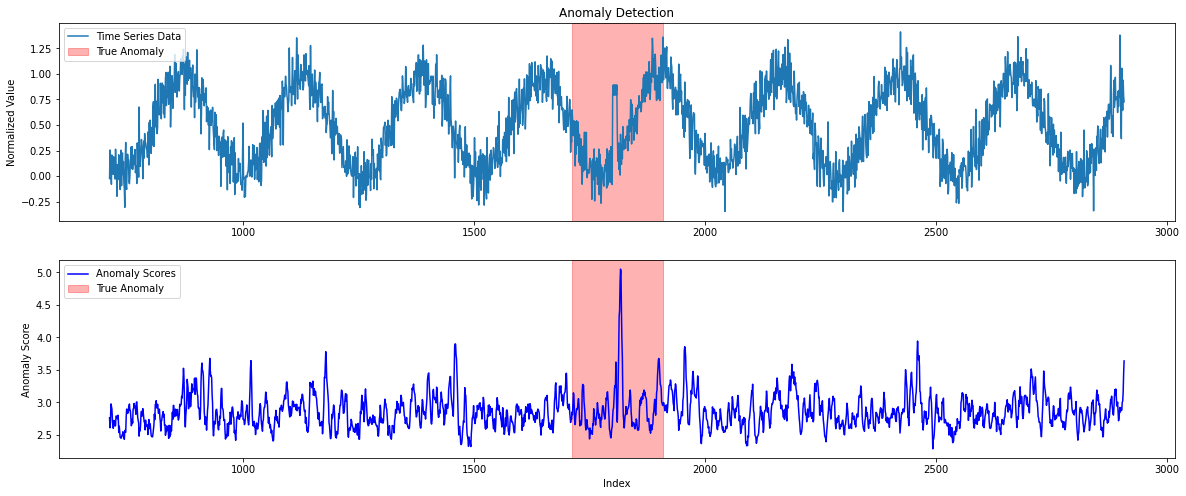

In [14]:
import numpy as np
import matplotlib.pyplot as plt


start_index = max(0, true_anomaly_start - 1000)
end_index = min(len(data), true_anomaly_end + 1000)

train_length_in_range = max(0, train_length - start_index)

anomaly_start_in_range = true_anomaly_start - start_index
anomaly_end_in_range = true_anomaly_end - start_index

x_values = np.arange(start_index, end_index)

data_in_range = data[start_index:end_index]
anomaly_scores_in_range = anomaly_scores[start_index:end_index]

plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
plt.plot(x_values, data_in_range, label='Time Series Data')
if train_length_in_range > 0 and train_length_in_range < len(x_values):
    plt.axvspan(x_values[0], x_values[train_length_in_range], color='gray', alpha=0.3, label='Train Data')
plt.axvspan(x_values[anomaly_start_in_range], x_values[anomaly_end_in_range], color='red', alpha=0.3, label='True Anomaly')
plt.ylabel('Normalized Value')
plt.title('Anomaly Detection')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(x_values, anomaly_scores_in_range, color='blue', label='Anomaly Scores')
if train_length_in_range > 0 and train_length_in_range < len(x_values):
    plt.axvspan(x_values[0], x_values[train_length_in_range], color='gray', alpha=0.3, label='Train Data')
plt.axvspan(x_values[anomaly_start_in_range], x_values[anomaly_end_in_range], color='red', alpha=0.3, label='True Anomaly')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')

print('True Anomaly Start:', true_anomaly_start, 'End:', true_anomaly_end)
print('Max Anomaly Score Index:', np.argmax(anomaly_scores), 'Window Size:', window_size)

plt.show()

In [29]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from minirocket import fit, transform
from sklearn.decomposition import PCA
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from joblib import Parallel, delayed
from scipy.signal import stft

def KNN(k_neighbors, train_windows, test_windows):
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(train_windows)
    distances, indices = nbrs.kneighbors(test_windows)
    avg_distances = distances.mean(axis=1)
    return avg_distances

def MiniRocket_KNN_fit(train_windows, num_features=100):
    train_windows = train_windows.astype(np.float32)
    para = fit(train_windows, num_features=num_features)
    return para

def mutual_information(X, Y):
    """Calculate mutual information between two arrays."""
    return mutual_info_score(X, Y)

def calculate_entropy(X):
    """Calculate entropy for a single array."""
    return entropy(X)

def calculate_energy_parallel(train_windows, keep_features_ratio=0.1, num_samples=100):
    """
    计算能量函数以选择最有用的特征。
    """
    num_features = train_windows.shape[1]
    num_pairs = int(num_features * (num_features - 1) / 2)
    
    sampled_pairs = np.random.choice(num_pairs, size=min(num_samples, num_pairs), replace=False)
    
    entropies = Parallel(n_jobs=-1)(delayed(calculate_entropy)(train_windows[:, i]) for i in range(num_features))
    entropies = np.array(entropies)
    
    energy = np.zeros(num_features)
    
    def calculate_pair_energy(i, j):
        mi = mutual_information(train_windows[:, i], train_windows[:, j])
        energy[i] -= mi
        energy[j] -= mi
    
    Parallel(n_jobs=-1)(delayed(calculate_pair_energy)(i, j) for i in range(num_features) for j in range(i + 1, num_features) if (i * num_features + j - (i + 1) * (i + 2) // 2) in sampled_pairs)
    
    energy += entropies
    
    keep_features = int(keep_features_ratio * num_features)
    keep_indices = np.argsort(energy)[:keep_features]
    
    return keep_indices

def MiniRocket_mask(para, train_windows, keep_features_ratio=0.1, num_samples=100):
    train_windows = train_windows.astype(np.float32)
    transformed_data = transform(train_windows, para)
    filter_type = 'energy'
    if keep_features_ratio == 1.0 or transformed_data.shape[1] == 0:
        mask = np.ones(transformed_data.shape[1]) if transformed_data.shape[1] > 0 else np.array([])
        return mask

    if filter_type == 'energy':
        keep_indices = calculate_energy_parallel(transformed_data, keep_features_ratio, num_samples)
        mask = np.zeros(transformed_data.shape[1])

    elif filter_type == 'std':
        std_devs = np.std(transformed_data, axis=0)
        keep_features = int(keep_features_ratio * transformed_data.shape[1])
        keep_indices = np.argpartition(std_devs, -keep_features)[-keep_features:]
        mask = np.zeros_like(std_devs)

    mask[keep_indices] = 1.0
    return mask

def remove_masked_columns(data, mask):
    keep_indices = np.where(mask != 0)[0]
    cleaned_data = data[:, keep_indices] if keep_indices.size > 0 else data
    return cleaned_data

def compute_stft_features(data_windows, fs=1.0, window='hann', nperseg=None, noverlap=None):
    if nperseg is None:
        nperseg = data_windows.shape[1]  # 默认窗口大小

    stft_features = []
    for window_data in data_windows:
        f, t, Zxx = stft(window_data.flatten(), fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
        magnitude = np.abs(Zxx).flatten()
        stft_features.append(magnitude)
    stft_features = np.array(stft_features)
    return stft_features

def MiniRocket_STFT_KNN(para, mask, k_neighbors, train_windows, test_windows=None, use_pca=False, pca_variance_ratio=0.8):
    # MiniRocket 特征提取
    # 确保输入数据类型为 np.float32
    train_windows = train_windows.astype(np.float32)
    if test_windows is not None:
        test_windows = test_windows.astype(np.float32)
        
    train_minirocket_features = transform(train_windows, para)
    train_minirocket_features = remove_masked_columns(train_minirocket_features, mask)
    if test_windows is not None:
        test_minirocket_features = transform(test_windows, para)
        test_minirocket_features = remove_masked_columns(test_minirocket_features, mask)
    else:
        test_minirocket_features = None

    # STFT 特征提取（在原始时间序列上）
    train_stft_features = compute_stft_features(train_windows)
    if test_windows is not None:
        test_stft_features = compute_stft_features(test_windows)
    else:
        test_stft_features = None

    # 特征融合
    train_features = np.concatenate((train_minirocket_features, train_stft_features), axis=1)
    if test_windows is not None:
        test_features = np.concatenate((test_minirocket_features, test_stft_features), axis=1)
    else:
        test_features = None

    # 可选：特征归一化
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    if test_features is not None:
        test_features = scaler.transform(test_features)

    # 可选：PCA 降维
    if use_pca:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=pca_variance_ratio)
        train_features = pca.fit_transform(train_features)
        if test_features is not None:
            test_features = pca.transform(test_features)

    # KNN 异常检测
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(train_features)
    if test_features is not None:
        distances, _ = nbrs.kneighbors(test_features)
    else:
        distances, _ = nbrs.kneighbors(train_features)
    avg_distances = distances.mean(axis=1)

    return avg_distances


In [30]:
#read data from data/UCR/135_UCR
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from scipy.signal import find_peaks, correlate
import math
import pandas as pd
import json
import time

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

dataset = 'UCR'

#window_sizes = [10, 50, 100, 200]
k_neighbors = 3
model = 'MiniRocket_KNN'

def calculate_window_size(data):
    # Calculate autocorrelation
    autocor = correlate(data, data, mode='full')
    autocor = autocor[len(autocor)//2:]

    # Define the range for finding peaks
    peak_range = np.arange(10, min(len(autocor), 1001))

    # Find peaks in the specified range of the autocorrelation
    peaks, _ = find_peaks(autocor[peak_range], distance=10)
    
    # Adjust peak indices to correspond to the original autocorrelation
    peaks = peak_range[peaks]
    
    # Set window size based on the first peak found
    if len(peaks) > 0:
        #print(peaks)
        m = peaks[0]
    else:
        m = 80
    
    return int(np.floor(m))

def select_window_sizes(upper_bound, lower_bound=10, num_candidates=4):
    # Ensure the upper bound is greater than the lower bound
    if upper_bound <= lower_bound:
        raise ValueError("Upper bound must be greater than lower bound.")
    
    # Calculate evenly spaced candidates within the range
    window_sizes = np.linspace(lower_bound, upper_bound, num_candidates, dtype=int)
    
    return window_sizes

def select_incremental_window_sizes(upper_bound, lower_bound=10, num_candidates=4):
    increment = (upper_bound - lower_bound) // (num_candidates - 1)
    return np.unique([lower_bound + i * increment for i in range(num_candidates)])

def select_best_window_size(point_anomaly_scores_list, window_sizes):
    max_differences = []
    
    for i, scores in enumerate(point_anomaly_scores_list):
        # Find the highest anomaly score and its index
        max_score = np.max(scores)
        max_index = np.argmax(scores)
        
        # Define the exclusion range for the second-highest point
        exclusion_start = max(0, max_index - window_sizes[i])
        exclusion_end = min(len(scores), max_index + window_sizes[i])
        
        # Mask out the range around the highest point
        masked_scores = np.copy(scores)
        masked_scores[exclusion_start:exclusion_end] = -np.inf  # Exclude this range by setting to -inf

        # Find the second-highest score outside the exclusion range
        second_max_score = np.max(masked_scores)
        
        # Calculate the score difference for the current window size
        score_difference = max_score - second_max_score
        max_differences.append(score_difference)
        
    # Find the window size with the maximum score difference
    best_index = np.argmax(max_differences)
    best_window_size = window_sizes[best_index]
    anomaly_scores = point_anomaly_scores_list[best_index]
    
    return best_window_size, anomaly_scores

def detect_delimiter(file_path):
    with open(file_path, 'r') as file:
        line = file.readline()
        if ',' in line:
            return ','
        elif '\t' in line:
            return '\t'
        else:
            return ' '
        
if dataset == 'UCR':
    dataset_folder = "E:\\Code\\Time_Series_Datasets\\UCR_Anomaly_FullData"
    file_list = os.listdir(dataset_folder)
    #file_list = file_list[188:189]

elif dataset == 'NAB':
    dataset_folder = 'data/NAB'
    file_list = os.listdir(dataset_folder)
    with open(dataset_folder + '/labels.json') as f:
        labeldict = json.load(f)
    file_list = file_list[1:2]

elif dataset == 'MSDS':
    dataset_folder = 'data/MSDS'
    file_list = os.listdir(dataset_folder)

elif dataset == 'SWaT':
    dataset_folder = 'data/SWaT'
    file_list = os.listdir(dataset_folder)
               
accuracy_scores = 0

# Result storage list
results = []
start_time = time.time()
for filename in file_list:
    print(filename)

    if dataset == 'UCR':
        if not filename.endswith('.txt'): continue
        vals = filename.split('.')[0].split('_')
        dnum, vals = int(vals[0]), vals[-3:]
        vals = [int(i) for i in vals]
        #delimiter = detect_delimiter(os.path.join(dataset_folder, filename))
        #temp = np.genfromtxt(os.path.join(dataset_folder, filename), dtype=np.float64, delimiter=delimiter)
        temp = np.loadtxt(dataset_folder + '\\' + filename)
        min_temp, max_temp = np.min(temp), np.max(temp)
        temp = (temp - min_temp) / (max_temp - min_temp)
        train, test = temp[:vals[0]], temp[vals[0]:]
        labels = np.zeros_like(test)
        labels[vals[1]-vals[0]:vals[2]-vals[0]] = 1
        train, test, labels = train.reshape(-1, 1), test.reshape(-1, 1), labels.reshape(-1, 1)
    else:
        pass
    
    data = np.concatenate([train, test], axis=0)
    
    window_size = calculate_window_size(train.flatten())
    window_sizes = select_incremental_window_sizes(upper_bound=window_size, lower_bound=10, num_candidates=4)
    print('Window Sizes:', window_sizes)
    
    
    # Segment time series into subsequences
    def create_windows(data, window_size):
        windows = []
        for i in range(len(data) - window_size + 1):
            windows.append(data[i:i + window_size])
        return np.array(windows)
    
    anomaly_scores_list = []
    for window_size in window_sizes:
        # Generate windows for train and test data separately
        train_windows = create_windows(train, window_size)
        test_windows = create_windows(test, window_size)
        train_windows = train_windows.reshape(-1, window_size)
        test_windows = test_windows.reshape(-1, window_size)

        #print('Train Windows:', train_windows.shape)

        # Calculate distances
        if model == 'KNN':
            train_distances = KNN(k_neighbors, train_windows, train_windows)
            test_distances = KNN(k_neighbors, train_windows, test_windows)
        elif model == 'MiniRocket_KNN':
            num_features = 1000
            use_pca = False
            pca_variance_ratio = 0.95
            para = MiniRocket_KNN_fit(train_windows, num_features=num_features)
            mask = MiniRocket_mask(para, train_windows, keep_features_ratio=0.5, num_samples=100)
            train_distances = MiniRocket_STFT_KNN(para, mask, k_neighbors, train_windows, use_pca=use_pca)
            test_distances = MiniRocket_STFT_KNN(para, mask, k_neighbors, train_windows, test_windows, use_pca=use_pca, pca_variance_ratio=pca_variance_ratio)
            #print(test_distances.shape)
        # Calculate anomaly score (train_distances and test_distances)
        train_distances = np.concatenate([train_distances, np.zeros(window_size-1)])
        test_distances = np.concatenate([test_distances, np.zeros(window_size-1)])
        anomaly_scores = np.concatenate([train_distances, test_distances])
        anomaly_scores_list.append(anomaly_scores)

    # Select the best window size based on the point anomaly scores
    best_window_size, anomaly_scores = select_best_window_size(anomaly_scores_list, window_sizes)
    print('Best Window Size:', best_window_size)
    #anomaly_scores = anomaly_scores[:len(data)]

    # Set threshold
    #threshold = max(anomaly_scores[:vals[0]])
    #anomalies = anomaly_scores > threshold

    # True label
    true_anomaly_start = vals[1]
    true_anomaly_end = vals[2]

    # Eval
    test_labels = labels[:-window_size+1]

    init_score = train_distances
    test_score = test_distances

    anomaly_location = np.argmax(anomaly_scores)  # Location of the predicted anomaly
    L = max(100, true_anomaly_end - true_anomaly_start)
    is_anomaly_correct = 0
    if true_anomaly_start - L <= anomaly_location <= true_anomaly_end + L:
        accuracy_scores += 1
        is_anomaly_correct = 1
    results.append({"Dataset": filename, "Anomaly_Detected": is_anomaly_correct, "Best Window Size": best_window_size})

# Calculate the average scores
accuracy_scores = accuracy_scores / len(file_list)

results_df = pd.DataFrame(results)
results_df.to_csv("anomaly_detection_results_stft.csv", index=False)
print("Time taken:", round(time.time() - start_time, 2), "seconds")

print("Average Accuracy Score:", accuracy_scores)

001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt
Window Sizes: [10 32 54 76]


KeyboardInterrupt: 

len of anomaly: 1
158250 158251
157987 158456


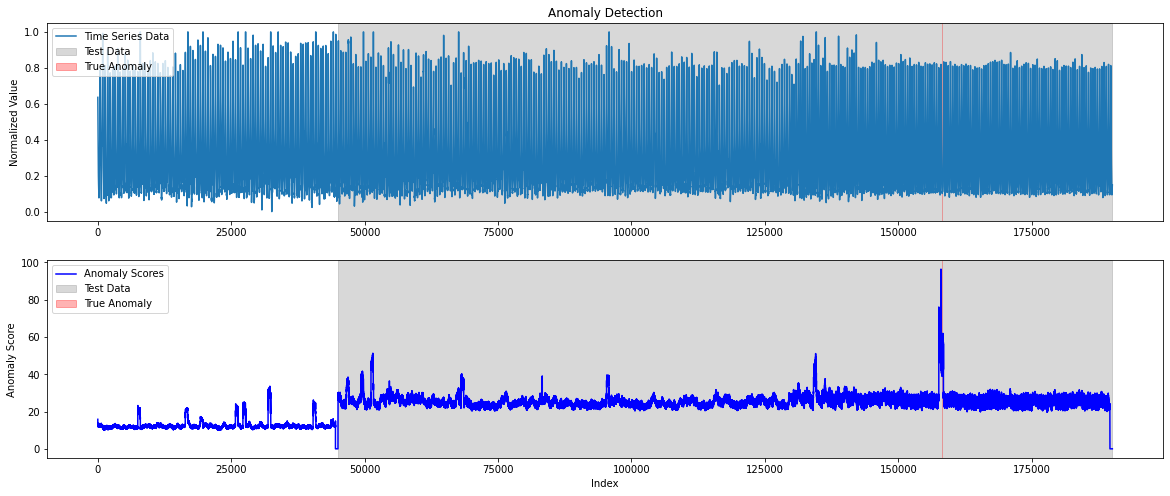

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables are defined: data, train, test, true_anomaly_start, true_anomaly_end, anomaly_scores, threshold, anomalies

# Define the length of training data
train_length = len(train)
print('len of anomaly:', true_anomaly_end - true_anomaly_start)

# Plotting
plt.figure(figsize=(20, 8))

# Upper plot - Time series data and detected anomalies
plt.subplot(2, 1, 1)
plt.plot(data, label='Time Series Data')
plt.axvspan(train_length, len(data), color='gray', alpha=0.3, label='Test Data')
plt.axvspan(true_anomaly_start, true_anomaly_end, color='red', alpha=0.3, label='True Anomaly')
#anomaly_indices = np.where(anomalies)[0] + train_length + window_size // 2
#plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label='Detected Anomaly')
plt.ylabel('Normalized Value')
plt.title('Anomaly Detection')
plt.legend(loc='upper left')

# Lower plot - Anomaly scores
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(anomaly_scores)), anomaly_scores, color='blue', label='Anomaly Scores')
plt.axvspan(train_length, len(data), color='gray', alpha=0.3, label='Test Data')
plt.axvspan(true_anomaly_start, true_anomaly_end, color='red', alpha=0.3, label='True Anomaly')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
print(true_anomaly_start, true_anomaly_end)
print(np.argmax(anomaly_scores), np.argmax(anomaly_scores)+window_size)

plt.show()

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from minirocket import fit, transform
from sklearn.decomposition import PCA
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
from joblib import Parallel, delayed
import pywt

def KNN(k_neighbors, train_windows, test_windows):
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(train_windows)
    distances, indices = nbrs.kneighbors(test_windows)
    avg_distances = distances.mean(axis=1)
    return avg_distances

def MiniRocket_KNN_fit(train_windows, num_features=100):
    train_windows = train_windows.astype(np.float32)
    para = fit(train_windows, num_features=num_features)
    return para

def mutual_information(X, Y):
    """Calculate mutual information between two arrays."""
    return mutual_info_score(X, Y)

def calculate_entropy(X):
    """Calculate entropy for a single array."""
    return entropy(X)

def calculate_energy_parallel(train_windows, keep_features_ratio=0.1, num_samples=100):
    num_features = train_windows.shape[1]
    num_pairs = int(num_features * (num_features - 1) / 2)
    
    sampled_pairs = np.random.choice(num_pairs, size=min(num_samples, num_pairs), replace=False)
    
    entropies = Parallel(n_jobs=-1)(delayed(calculate_entropy)(train_windows[:, i]) for i in range(num_features))
    entropies = np.array(entropies)
    
    energy = np.zeros(num_features)
    
    def calculate_pair_energy(i, j):
        mi = mutual_information(train_windows[:, i], train_windows[:, j])
        energy[i] -= mi
        energy[j] -= mi
    
    Parallel(n_jobs=-1)(delayed(calculate_pair_energy)(i, j) for i in range(num_features) for j in range(i + 1, num_features) if (i * num_features + j - (i + 1) * (i + 2) // 2) in sampled_pairs)
    
    energy += entropies
    
    keep_features = int(keep_features_ratio * num_features)
    keep_indices = np.argsort(energy)[:keep_features]
    
    return keep_indices

def MiniRocket_mask(para, train_windows, keep_features_ratio=0.1, num_samples=100):
    train_windows = train_windows.astype(np.float32)
    transformed_data = transform(train_windows, para)
    filter_type = 'energy'
    if keep_features_ratio == 1.0 or transformed_data.shape[1] == 0:
        mask = np.ones(transformed_data.shape[1]) if transformed_data.shape[1] > 0 else np.array([])
        return mask

    if filter_type == 'energy':
        keep_indices = calculate_energy_parallel(transformed_data, keep_features_ratio, num_samples)
        mask = np.zeros(transformed_data.shape[1])

    elif filter_type == 'std':
        std_devs = np.std(transformed_data, axis=0)
        keep_features = int(keep_features_ratio * transformed_data.shape[1])
        keep_indices = np.argpartition(std_devs, -keep_features)[-keep_features:]
        mask = np.zeros_like(std_devs)

    mask[keep_indices] = 1.0
    return mask

def remove_masked_columns(data, mask):
    keep_indices = np.where(mask != 0)[0]
    cleaned_data = data[:, keep_indices] if keep_indices.size > 0 else data
    return cleaned_data

def compute_wavelet_features(data_windows, wavelet='db4', level=None):
    wavelet_features = []
    for window_data in data_windows:
        coeffs = pywt.wavedec(window_data.flatten(), wavelet=wavelet, level=level)
        features = np.concatenate(coeffs)
        wavelet_features.append(features)
    wavelet_features = np.array(wavelet_features)
    return wavelet_features

def MiniRocket_Wavelet_KNN(para, mask, k_neighbors, train_windows, test_windows=None, wavelet='db4', level=None, use_pca=False, pca_variance_ratio=0.8):
    train_windows = train_windows.astype(np.float32)
    if test_windows is not None:
        test_windows = test_windows.astype(np.float32)
    
    # MiniRocket 特征提取
    train_minirocket_features = transform(train_windows, para)
    train_minirocket_features = remove_masked_columns(train_minirocket_features, mask)
    if test_windows is not None:
        test_minirocket_features = transform(test_windows, para)
        test_minirocket_features = remove_masked_columns(test_minirocket_features, mask)
    else:
        test_minirocket_features = None

    # 小波特征提取
    train_wavelet_features = compute_wavelet_features(train_windows, wavelet=wavelet, level=level)
    if test_windows is not None:
        test_wavelet_features = compute_wavelet_features(test_windows, wavelet=wavelet, level=level)
    else:
        test_wavelet_features = None

    # 特征融合
    train_features = np.concatenate((train_minirocket_features, train_wavelet_features), axis=1)
    if test_windows is not None:
        test_features = np.concatenate((test_minirocket_features, test_wavelet_features), axis=1)
    else:
        test_features = None

    # 特征归一化（可选）
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    if test_features is not None:
        test_features = scaler.transform(test_features)

    # 应用 PCA（可选）
    if use_pca:
        pca = PCA(n_components=pca_variance_ratio)
        train_features = pca.fit_transform(train_features)
        if test_features is not None:
            test_features = pca.transform(test_features)

    # KNN 异常检测
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto').fit(train_features)
    if test_features is not None:
        distances, _ = nbrs.kneighbors(test_features)
    else:
        distances, _ = nbrs.kneighbors(train_features)
    avg_distances = distances.mean(axis=1)

    return avg_distances

In [ ]:
#read data from data/UCR/135_UCR
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from scipy.signal import find_peaks, correlate
import math
import pandas as pd
import json
import time

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

dataset = 'UCR'

#window_sizes = [10, 50, 100, 200]
k_neighbors = 3
model = 'MiniRocket_KNN'

def calculate_window_size(data):
    # Calculate autocorrelation
    autocor = correlate(data, data, mode='full')
    autocor = autocor[len(autocor)//2:]

    # Define the range for finding peaks
    peak_range = np.arange(10, min(len(autocor), 1001))

    # Find peaks in the specified range of the autocorrelation
    peaks, _ = find_peaks(autocor[peak_range], distance=10)
    
    # Adjust peak indices to correspond to the original autocorrelation
    peaks = peak_range[peaks]
    
    # Set window size based on the first peak found
    if len(peaks) > 0:
        #print(peaks)
        m = peaks[0]
    else:
        m = 80
    
    return int(np.floor(m))

def select_window_sizes(upper_bound, lower_bound=10, num_candidates=4):
    # Ensure the upper bound is greater than the lower bound
    if upper_bound <= lower_bound:
        raise ValueError("Upper bound must be greater than lower bound.")
    
    # Calculate evenly spaced candidates within the range
    window_sizes = np.linspace(lower_bound, upper_bound, num_candidates, dtype=int)
    
    return window_sizes

def select_incremental_window_sizes(upper_bound, lower_bound=10, num_candidates=4):
    increment = (upper_bound - lower_bound) // (num_candidates - 1)
    return np.unique([lower_bound + i * increment for i in range(num_candidates)])

def select_best_window_size(point_anomaly_scores_list, window_sizes):
    max_differences = []
    
    for i, scores in enumerate(point_anomaly_scores_list):
        # Find the highest anomaly score and its index
        max_score = np.max(scores)
        max_index = np.argmax(scores)
        
        # Define the exclusion range for the second-highest point
        exclusion_start = max(0, max_index - window_sizes[i])
        exclusion_end = min(len(scores), max_index + window_sizes[i])
        
        # Mask out the range around the highest point
        masked_scores = np.copy(scores)
        masked_scores[exclusion_start:exclusion_end] = -np.inf  # Exclude this range by setting to -inf

        # Find the second-highest score outside the exclusion range
        second_max_score = np.max(masked_scores)
        
        # Calculate the score difference for the current window size
        score_difference = max_score - second_max_score
        max_differences.append(score_difference)
        
    # Find the window size with the maximum score difference
    best_index = np.argmax(max_differences)
    best_window_size = window_sizes[best_index]
    anomaly_scores = point_anomaly_scores_list[best_index]
    
    return best_window_size, anomaly_scores

def detect_delimiter(file_path):
    with open(file_path, 'r') as file:
        line = file.readline()
        if ',' in line:
            return ','
        elif '\t' in line:
            return '\t'
        else:
            return ' '
        
if dataset == 'UCR':
    dataset_folder = "E:\\Code\\Time_Series_Datasets\\UCR_Anomaly_FullData"
    file_list = os.listdir(dataset_folder)
    file_list = file_list[188:189]

elif dataset == 'NAB':
    dataset_folder = 'data/NAB'
    file_list = os.listdir(dataset_folder)
    with open(dataset_folder + '/labels.json') as f:
        labeldict = json.load(f)
    file_list = file_list[1:2]

elif dataset == 'MSDS':
    dataset_folder = 'data/MSDS'
    file_list = os.listdir(dataset_folder)

elif dataset == 'SWaT':
    dataset_folder = 'data/SWaT'
    file_list = os.listdir(dataset_folder)
               
accuracy_scores = 0

# Result storage list
results = []
start_time = time.time()
for filename in file_list:
    print(filename)

    if dataset == 'UCR':
        if not filename.endswith('.txt'): continue
        vals = filename.split('.')[0].split('_')
        dnum, vals = int(vals[0]), vals[-3:]
        vals = [int(i) for i in vals]
        #delimiter = detect_delimiter(os.path.join(dataset_folder, filename))
        #temp = np.genfromtxt(os.path.join(dataset_folder, filename), dtype=np.float64, delimiter=delimiter)
        temp = np.loadtxt(dataset_folder + '\\' + filename)
        min_temp, max_temp = np.min(temp), np.max(temp)
        temp = (temp - min_temp) / (max_temp - min_temp)
        train, test = temp[:vals[0]], temp[vals[0]:]
        labels = np.zeros_like(test)
        labels[vals[1]-vals[0]:vals[2]-vals[0]] = 1
        train, test, labels = train.reshape(-1, 1), test.reshape(-1, 1), labels.reshape(-1, 1)
    else:
        pass
    
    data = np.concatenate([train, test], axis=0)
    
    window_size = calculate_window_size(train.flatten())
    window_sizes = select_incremental_window_sizes(upper_bound=window_size, lower_bound=10, num_candidates=4)
    print('Window Sizes:', window_sizes)
    
    
    # Segment time series into subsequences
    def create_windows(data, window_size):
        windows = []
        for i in range(len(data) - window_size + 1):
            windows.append(data[i:i + window_size])
        return np.array(windows)
    
    anomaly_scores_list = []
    for window_size in window_sizes:
        # Generate windows for train and test data separately
        train_windows = create_windows(train, window_size)
        test_windows = create_windows(test, window_size)
        train_windows = train_windows.reshape(-1, window_size)
        test_windows = test_windows.reshape(-1, window_size)

        #print('Train Windows:', train_windows.shape)

        # Calculate distances
        if model == 'KNN':
            train_distances = KNN(k_neighbors, train_windows, train_windows)
            test_distances = KNN(k_neighbors, train_windows, test_windows)
        elif model == 'MiniRocket_KNN':
            num_features = 1000
            use_pca = False
            pca_variance_ratio = 0.95
            para = MiniRocket_KNN_fit(train_windows, num_features=num_features)
            mask = MiniRocket_mask(para, train_windows, keep_features_ratio=0.5, num_samples=100)
            train_distances = MiniRocket_Wavelet_KNN(para, mask, k_neighbors, train_windows, use_pca=use_pca)
            test_distances = MiniRocket_Wavelet_KNN(para, mask, k_neighbors, train_windows, test_windows, use_pca=use_pca, pca_variance_ratio=pca_variance_ratio)
            #print(test_distances.shape)
        # Calculate anomaly score (train_distances and test_distances)
        train_distances = np.concatenate([train_distances, np.zeros(window_size-1)])
        test_distances = np.concatenate([test_distances, np.zeros(window_size-1)])
        anomaly_scores = np.concatenate([train_distances, test_distances])
        anomaly_scores_list.append(anomaly_scores)

    # Select the best window size based on the point anomaly scores
    best_window_size, anomaly_scores = select_best_window_size(anomaly_scores_list, window_sizes)
    print('Best Window Size:', best_window_size)
    #anomaly_scores = anomaly_scores[:len(data)]

    # Set threshold
    #threshold = max(anomaly_scores[:vals[0]])
    #anomalies = anomaly_scores > threshold

    # True label
    true_anomaly_start = vals[1]
    true_anomaly_end = vals[2]

    # Eval
    test_labels = labels[:-window_size+1]

    init_score = train_distances
    test_score = test_distances

    anomaly_location = np.argmax(anomaly_scores)  # Location of the predicted anomaly
    L = max(100, true_anomaly_end - true_anomaly_start)
    is_anomaly_correct = 0
    if true_anomaly_start - L <= anomaly_location <= true_anomaly_end + L:
        accuracy_scores += 1
        is_anomaly_correct = 1
    results.append({"Dataset": filename, "Anomaly_Detected": is_anomaly_correct, "Best Window Size": best_window_size})

# Calculate the average scores
accuracy_scores = accuracy_scores / len(file_list)

results_df = pd.DataFrame(results)
results_df.to_csv("anomaly_detection_results_wavelet.csv", index=False)
print("Time taken:", round(time.time() - start_time, 2), "seconds")

print("Average Accuracy Score:", accuracy_scores)

189_UCR_Anomaly_resperation3_45000_158250_158251.txt
Window Sizes: [ 10 163 316 469]
Best Window Size: 469
Time taken: 161.38 seconds
Average Accuracy Score: 0.0


len of anomaly: 1
158250 158251
68551 69020


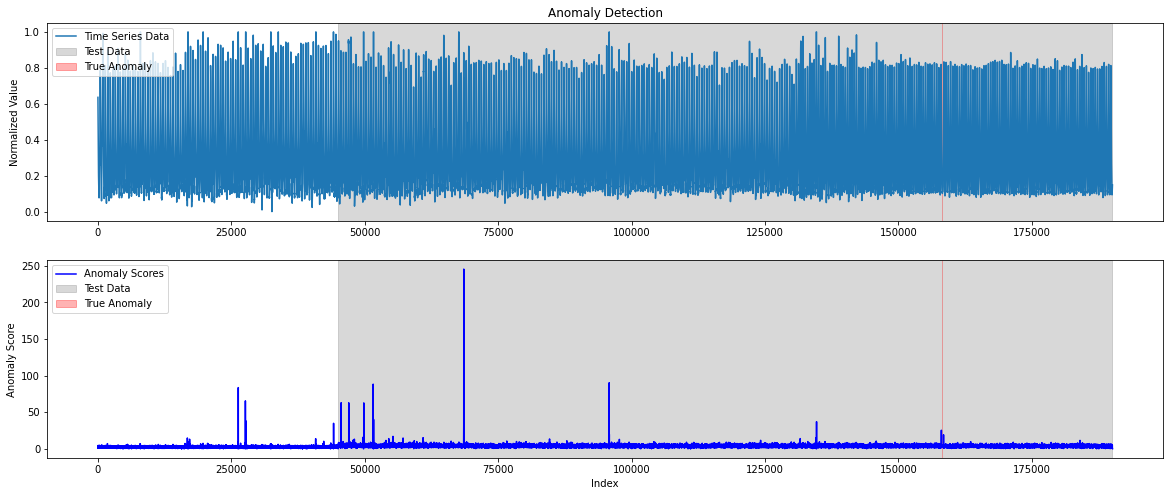

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these variables are defined: data, train, test, true_anomaly_start, true_anomaly_end, anomaly_scores, threshold, anomalies

# Define the length of training data
train_length = len(train)
print('len of anomaly:', true_anomaly_end - true_anomaly_start)

# Plotting
plt.figure(figsize=(20, 8))

# Upper plot - Time series data and detected anomalies
plt.subplot(2, 1, 1)
plt.plot(data, label='Time Series Data')
plt.axvspan(train_length, len(data), color='gray', alpha=0.3, label='Test Data')
plt.axvspan(true_anomaly_start, true_anomaly_end, color='red', alpha=0.3, label='True Anomaly')
#anomaly_indices = np.where(anomalies)[0] + train_length + window_size // 2
#plt.scatter(anomaly_indices, data[anomaly_indices], color='red', label='Detected Anomaly')
plt.ylabel('Normalized Value')
plt.title('Anomaly Detection')
plt.legend(loc='upper left')

# Lower plot - Anomaly scores
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(anomaly_scores)), anomaly_scores, color='blue', label='Anomaly Scores')
plt.axvspan(train_length, len(data), color='gray', alpha=0.3, label='Test Data')
plt.axvspan(true_anomaly_start, true_anomaly_end, color='red', alpha=0.3, label='True Anomaly')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper left')
print(true_anomaly_start, true_anomaly_end)
print(np.argmax(anomaly_scores), np.argmax(anomaly_scores)+window_size)

plt.show()